In [47]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

In [48]:
import seaborn as sns
iris = sns.load_dataset('iris')

In [49]:
data = torch.tensor(iris[iris.columns[0:4]].values).float()

labels = torch.zeros(len(data), dtype=torch.long)

labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [50]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

train_data = torch.utils.data.TensorDataset(train_data, train_labels)
test_data = torch.utils.data.TensorDataset(test_data, test_labels)

batchSize = 16
train_loader = DataLoader(train_data, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [51]:
def createANNmodel(L2lambda):
    ANN = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
    )

    lossfun = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(params=ANN.parameters(), lr=0.005, weight_decay=L2lambda)

    return ANN, lossfun, optimizer

In [52]:
numEpochs = 1000

def trainTheModel():
    trainAcc = []
    testAcc = []
    losses = []

    for epochi in range(numEpochs):
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:
            yHat = ANN(X)

            loss = lossfun(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
            batchLoss.append(loss.item())

        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        ANN.eval()
        X,y = next(iter(test_loader))
        predlabels = torch.argmax(ANN(X),axis=1)
        testAcc.append(100*torch.mean((predlabels==y).float()).item())

        ANN.train()

    return trainAcc, testAcc, losses

In [53]:
L2lambda = .01

ANN, lossfun, optimizer = createANNmodel(L2lambda)

trainAcc, testAcc, losses = trainTheModel()

In [54]:
def smooth(x, k=5):
    return np.convolve(x, np.ones(k)/k, mode='same')

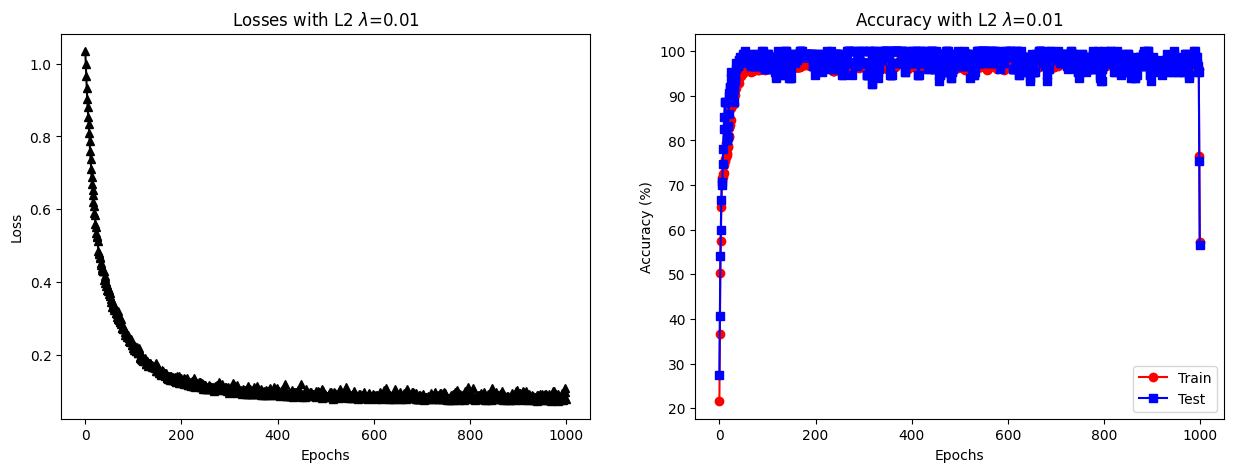

In [55]:
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L2 $\lambda$=' + str(L2lambda))

ax[1].plot(smooth(trainAcc, 5),'ro-')
ax[1].plot(smooth(testAcc, 5),'bs-')
ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

In [56]:
L2lambdas = np.linspace(0,.1,10)

accuracyResultsTrain = np.zeros((numEpochs, len(L2lambdas)))
accuracyResultsTest = np.zeros((numEpochs, len(L2lambdas)))

for li in range(len(L2lambdas)):
    ANN, lossfun, optimizer = createANNmodel(L2lambdas[li])

    trainAcc, testAcc, losses = trainTheModel()

    accuracyResultsTrain[:,li] = smooth(trainAcc,10)
    accuracyResultsTest[:,li] = smooth(testAcc,10)

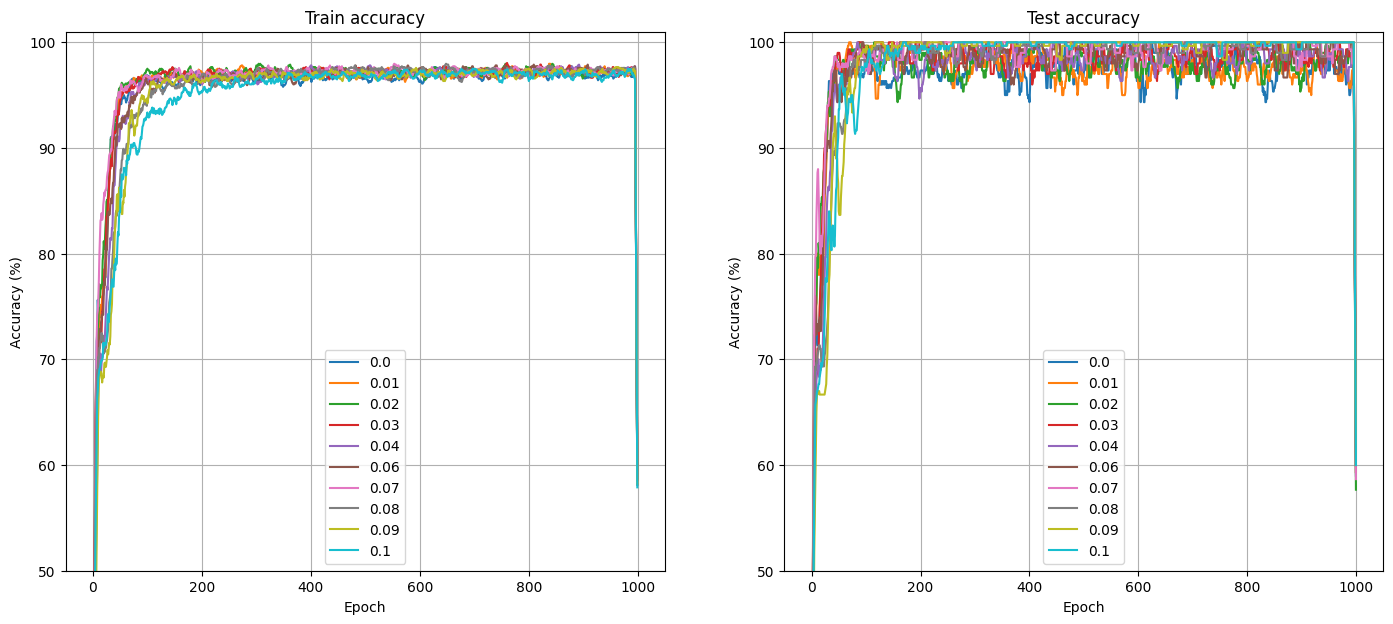

In [57]:
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

leglabels = [np.round(i,2) for i in L2lambdas]

for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

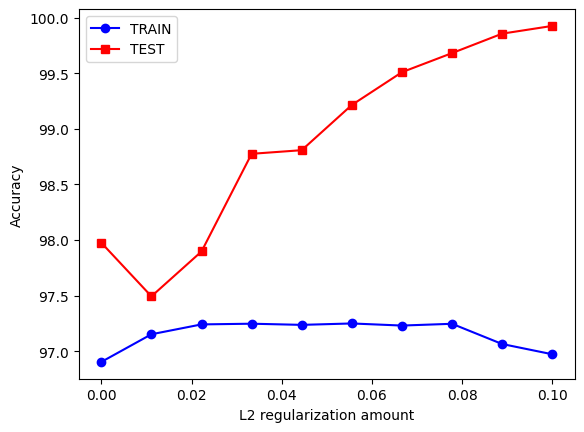

In [58]:
epoch_range = [500,950]


plt.plot(L2lambdas,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(L2lambdas,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()